In [11]:
import sqlite3
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from  keys  import  client_id, api_key
import folium

In [12]:
 # Creating a new DB and setting up cursor to it
conn = sqlite3.connect('coffee_places.db')
cursor = conn.cursor()

In [17]:
# Creating dictionary where each key represents table name in DB and value represents query with Create statement with columns

TABLES = {}
TABLES['business'] = (
    """CREATE TABLE business (
        business_id VARCHAR(30) NOT NULL,
        name TEXT,
        review_count INTEGER,
        rating DECIMAL,
        address TEXT,
        city TEXT,
        zip_code INTEGER NOT NULL,
        price TEXT,
        coordinate_latitude DECIMAL,
        coordinate_longtitude DECIMAL,
        PRIMARY KEY (business_id)
        );
    """)

TABLES['reviews'] = (
    """CREATE TABLE reviews (
        review_id VARCHAR(30) PRIMARY KEY,
        business_id VARCHAR(30) NOT NULL,
        rating DECIMAL,
        text TEXT,
        date_created TEXT,
        FOREIGN KEY (business_id)
            REFERENCES business (business_id)
        
        );
    """)

In [18]:
# Itareting trough dict TABLES and executing query incoded into value of the each dict.

for table_name in TABLES:
    table_description = TABLES[table_name]
    cursor.execute('DROP TABLE IF EXISTS {};'.format(table_name))
    cursor.execute(table_description)

In [19]:
# Setting UP variables which will be using for API request to yelp web 

url =  'https://api.yelp.com/v3/businesses/search'
headers = {'Authorization': 'Bearer {}'.format(api_key)}
term = 'Coffee Shop'
locations = ['Brooklyn', 'Queens']
categories = 'Coffee & tea'
price = [1,2,3,4]
limit = 50
cur = 0

In [20]:
# 

url_params = {
                "term": term.replace(' ', '+'),
                "location": locations,
                "categories" : categories,
                "price" : price,
                "limit" : limit,
                "offset" : cur
                
            }

In [21]:
zip_queens = [11361, 11362, 11363, 11364, 11354, 11355, 11356, 11357, 11358,
          11359, 11360, 11365, 11366, 11367, 11412, 11423, 11432, 11433,
          11434, 11435, 11436, 11101, 11102, 11103, 11104, 11105, 11106,
          11374, 11375, 11379, 11385, 11691, 11692, 11693, 11694, 11695,
          11697, 11004, 11005, 11411, 11413, 11422, 11426, 11427, 11428,
          11429, 11414, 11415, 11416, 11417, 11418, 11419, 11420, 11421,
          11368, 11369, 11370, 11372, 11373, 11377, 11378]

zip_bklyn = [11212, 11213, 11216, 11233, 11238, 11209, 11214, 11228, 11204, 11218,
          11219, 11230, 11234, 11236, 11239, 11223, 11224, 11229, 11235, 11201,
          11205, 11215, 11217, 11231, 11203, 11210, 11225, 11226, 11207, 11208,
          11211, 11222, 11220, 11232, 11206, 11221, 11237]

In [22]:
def yelp_call(url_params, api_key):
    """
    Sending API request.
    Returns data represented as list of dict.
    Each dict contain information about 1 buisness
    Params : url_params - dict
             api_key - unique key access to web
    
    """
    response = requests.get(url=url, headers=headers, params=url_params)
    data = json.loads(response.text)
    try:
        return data['businesses']
    except:
        print(data)
        return data

In [23]:
    
def parse_results(list_of_data):
    """
    parsing data by the keys.
    params : list_of_data - list of dict (each dict repr. 1 buisness)
    return : list of tuples with 10 elements in each
    """
    parsed_results = []
    for business in list_of_data:
        if int(business['location']['zip_code']) in zip_queens+zip_bklyn: # only takes bus located in Bklyn or Queens 
            bus_tup = (business['id'],
               business['name'],
               business['review_count'],
               business['rating'],
               ','.join(business['location']['display_address']),
               business['location']['city'],
               int(business['location']['zip_code']),
               business['price'],
               business['coordinates']['latitude'],
               business['coordinates']['longitude']
              )
            parsed_results.append(bus_tup)

    return parsed_results

In [25]:
def db_insert(cursor, parsed_results):
    """
    Inserting data into DB
    Params : cursor
             parsed_results - list of tuplease
    """
    
    insert_statement = '''INSERT INTO business (
        business_id,
        name,
        review_count,
        rating,
        address,
        city,
        zip_code,
        price,
        coordinate_latitude,
        coordinate_longtitude) VALUES ( ?, ?, ?, ?, ?, ?, ?, ?, ?, ? )'''

    cursor.executemany(insert_statement, parsed_results)

In [26]:
# Looping trough list of Location that we need to get data about
# sending each location to yelp as API reques
# getting back data then sending it to parce and collect it to all_results list
# callinf function db_insert to record parced data into table Buisness in DB

all_results =[]
for location in locations:
    url_params['location'] = location
    for cur in range(0,1000,50):
        url_params['offset'] = cur
        results = yelp_call(url_params, api_key)
        parsed_results = parse_results(results)
        all_results.extend(parsed_results)
db_insert(cursor, list(set(all_results)))

In [27]:
# Retriving business_id from DB Table business and collecting into list 
business_ids = [t[0] for t in cursor.execute("""SELECT business_id FROM business;""").fetchall()]

In [28]:
def yelp_review_call(url_params, api_key, business_id):
    """
    Sending API request to yelp web.
    Returns data represented as dict with 3 keys.
    Each dict contain information about 3 buisness reviews
    Params : url_params - dict
             api_key - unique key access to web
             business_id - string
    """
    response = requests.get(url='https://api.yelp.com/v3/businesses/{}/reviews'.format(business_id), headers=headers)
    data = json.loads(response.text)
    return data

In [29]:
def parse_review(review_respond, business_id):
    """
    parsing data by the keys.
    params : review_respond - dict
             business_id - string
    return : list of tuples with 6 elements in each
    """
    parsed_results = []
    
    for review in review_respond.get('reviews',[]):
        parsed_results.append((
            review['id'],
            business_id,
            review['rating'],
            review['text'],
            review['time_created']
        ))

    return parsed_results

In [33]:
def db_insert_reviews(cursor, reviews_list):
    """
    Inserting data into DB
    Params : cursor
             reviews_list - list of tuples
    """
    
    insert_statement = '''INSERT INTO reviews (
        review_id,
        business_id,
        rating,
        text,
        date_created) VALUES ( ?, ?, ?, ?, ? )'''

    cursor.executemany(insert_statement, reviews_list)

In [31]:
# iterating troug list of business_ids
# getting data respond as dict with 3 reviews for each buisness
# parsing those 3 reviews into list of tuples 
# collecting tuples in 1 list - all_reviews

all_reviews = []
for business_id in business_ids:
    review_respond = yelp_review_call(url_params, api_key, business_id)
    all_reviews.extend(parse_review(review_respond, business_id))

In [34]:
# Insering data - list of tuples into DB Table 'reviews'
db_insert_reviews(cursor, all_reviews)

# Which are the 5 most reviewed businesses?

In [35]:
cursor.execute(""" SELECT 
                    b.name
                    ,b.review_count
                    FROM business AS b
                    ORDER BY review_count DESC
                    LIMIT 5
                """).fetchall()

[('Martha’s Country Bakery', 2039),
 ('Sweet Chick', 2026),
 ('Buttermilk Channel', 1891),
 ('JoJu', 1703),
 ('Five Leaves', 1616)]

# What is the highest rating recieved in your data set and how many businesses have that rating?


In [36]:
cursor.execute(""" SELECT 
                    rating
                    ,COUNT(rating)
                    FROM business
                    WHERE rating = (SELECT MAX(rating) FROM business)
                """).fetchall()

[(5, 34)]

# What percentage of businesses have a rating greater than or 4.5?


In [37]:

cursor.execute(""" SELECT 
                    COUNT(*)*100/(SELECT COUNT(*) FROM business)
                    FROM business
                    WHERE rating >= 4.5
                """).fetchall()

[(35,)]

# What percentage of businesses have a rating less than 3?


In [38]:
n = cursor.execute(""" SELECT 
                    COUNT(*)
                    FROM business
                    WHERE rating < 3
                """).fetchall()[0][0]
d = cursor.execute(""" SELECT 
                    COUNT(*)
                    FROM business
                    --WHERE rating < 3
                """).fetchall()[0][0]

(n/d)*100

0.8733624454148471

# What is the average rating of businesses that have a price label of one dollar sign? Two dollar signs? Three dollar signs? 

In [39]:
cursor.execute(""" SELECT 
                    price
                    ,AVG(rating)
                    FROM business
                    --WHERE price = '$' OR price = '$$' OR price = '$$$' 
                    GROUP BY price
                """).fetchall()

[('$', 4.085043988269795),
 ('$$', 4.063235294117647),
 ('$$$', 3.9166666666666665)]

# Return the text of the reviews for the most reviewed business.


In [40]:

cursor.execute("""  SELECT
                    text
                    FROM reviews 
                    WHERE business_id IN 
     
                    (SELECT
                    b.business_id
                    FROM business AS b
                    WHERE review_count IN (SELECT MAX(b.review_count) FROM business AS b) )
                """).fetchall()

[("A must have treat! Just go in and pick anything, you won't be disappointed. The workers are super nice and up beat. I left with sweets and a smile! \n\nTheir...",),
 ("Have a sweet tooth?  No problem, just pay Martha's Country Bakery a visit and you won't regret it!  There are so many selections of cakes, pies, cookies,...",),
 ("I love the Martha's in Bayside by my house as well as this location. I've dined in with friends and ordered takeout too many times to count. The pastries...",)]

# Return the name of the business with the most recent review


In [41]:
# Use subq as consume less resourses
cursor.execute(""" SELECT
                    b.name
                    ,r.date_created
                    
                    FROM business b INNER JOIN reviews r
                    ON b.business_id = r.business_id
                    ORDER BY date_created DESC
                    LIMIT 1
                """).fetchall()

[('Crepe Factory', '2021-01-07 15:38:16')]

# Find the highest rated business and return text of the most recent review. If multiple business have the same rating, select the business with the most reviews.

In [42]:

cursor.execute(""" SELECT
                    b.name
                    ,r.date_created
                    ,b.rating
                    ,r.text
                    ,review_count
                    FROM business b INNER JOIN reviews r
                    ON b.business_id = r.business_id
                    --GROUP BY b.business_id
                    ORDER BY  b.rating DESC, b.review_count DESC, date_created DESC
                    LIMIT 1
                """).fetchall()

[('The Alcove',
  '2020-10-06 17:23:24',
  5,
  'Never bad, always amazing-- even in the midst of covid, and notoriously long wait times. \n\nThe food and flights always makes it all better.',
  897)]

# Find the lowest rated business and return text of the most recent review. If multiple business have the same rating, select the business with the least reviews.

In [43]:

cursor.execute(""" SELECT
                    b.name
                    ,r.date_created
                    ,b.rating
                    ,r.text
                    ,review_count
                    FROM business b INNER JOIN reviews r
                    ON b.business_id = r.business_id
                    GROUP BY b.business_id
                    ORDER BY  b.rating ASC, b.review_count DESC, date_created ASC
                    LIMIT 1
                """).fetchall()

[('Starbucks',
  '2020-06-12 14:26:31',
  2.5,
  "This isn't the worst location I've ever been to but it surely is not the best. The employees were fairly nice, but the quality of the drinks are not up to...",
  47)]

# Pulling in relevant data into your python environment and analysis it using descriptive statistics

In [44]:
dfb = pd.DataFrame(cursor.execute("SELECT * FROM business").fetchall())
dfb.columns = [x[0] for x in cursor.description]
dfb.head()

,business_id,name,review_count,rating,address,city,zip_code,price,coordinate_latitude,coordinate_longtitude
0,Y-WxfrESCAgeSmucYGmEJg,Turn the Page Again,50,4.5,"39-15 Bell Blvd,Bayside, NY 11361",Bayside,11361,$,40.764880,-73.771330
1,lUZbIxWf_eylfXcJcjdCBg,Two For the Pot,37,4.5,"200 Clinton St,Brooklyn, NY 11201",Brooklyn,11201,$$,40.690670,-73.994461
2,1VulIvaA95_ZjBIs1O0sxQ,Brooklyn Ball Factory,127,4.5,"95 Montrose Ave,Brooklyn, NY 11206",Brooklyn,11206,$$,40.707234,-73.945866
3,u_3TLN0u6LyOL01vdjFOug,Champs Diner,1563,4.0,"197 Meserole St,Brooklyn, NY 11206",Brooklyn,11206,$$,40.708440,-73.940781
4,rBCqVm8yhMKeLLP2mdghGw,Victory Sweet Shop,60,4.0,"2169 Steinway St,Astoria, NY 11105",Astoria,11105,$,40.773044,-73.905395


# Creating Map shoving density of Buisnesses in Queens and Brooklyn

In [45]:
# Changing 'city' column in DF business according to zip_codes

def filtering_city(row):
    
    if row['zip_code'] in zip_bklyn:
        row['city'] = 'Brooklyn'
    elif row['zip_code'] in zip_queens:
        row['city'] = 'Queens'
    return row

dfb = dfb.apply(filtering_city,axis=1)

In [50]:
# Creating map of Brooklyn-Queens where each poin represents buisness location

bq_coordinates =[(40.6501+40.68149)/2,(-73.94958-73.83652)/2]
business_data = dfb[['coordinate_latitude','coordinate_longtitude','name','address']].values

def map_from(location, zoom_amount):
    map_ =folium.Map(location=location, zoom_start=zoom_amount)
    return map_

def add_business_mark(bus_markers_list, map_obj):
    for marker in bus_markers_list:
        marker.add_to(map_obj)
    return map_obj

bq_map = map_from(bq_coordinates, 11)
bus_markers_list = [ folium.Circle([lat,long], radius=10, tooltip=name, popup='<i>{}</i>'.format(add)) for lat,long,name,add in business_data ]

add_business_mark(bus_markers_list, bq_map)

# Building Graf to Explore Number Of Businesess in Bklyn and Queens

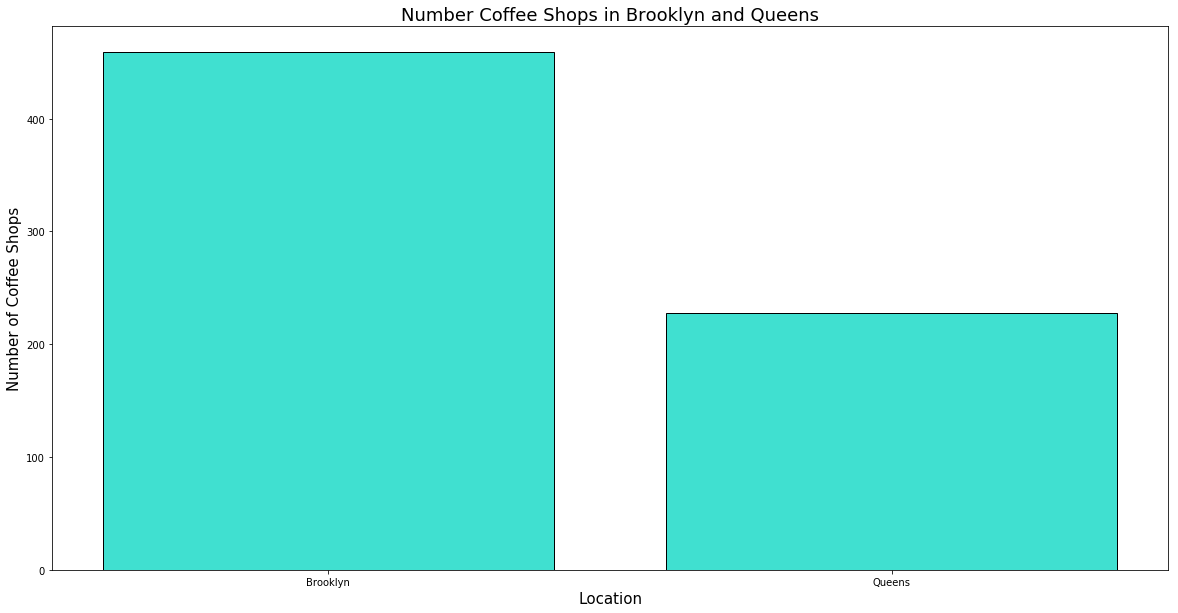

In [67]:
bus_count = dfb.groupby('city')['business_id'].count()

fig, ax = plt.subplots(figsize=(20,10))

ax.bar(bus_count.index, bus_count.values, color='turquoise', edgecolor= 'black', align='center')
ax.set_title('Number Coffee Shops in Brooklyn and Queens', size=18)
ax.set_ylabel('Number of Coffee Shops', size=15)
ax.set_xlabel('Location', size= 15)
plt.show()

# Scraping Data From web about zip and population in Bklyn and Queens. 

In [53]:
# creating a list of url records containing information about zip_codes and population in NYC

urls =['http://zipatlas.com/us/ny/zip-code-comparison/population-density.html'] \
    + [ 'http://zipatlas.com/us/ny/zip-code-comparison/population-density.{}.html'.format(i) for i in range(2,17)]

In [54]:
all_dfs = []

def format_table(df):
    """
    Formating each df returned
    From pd.readhtm()
    returns df
    """
    df.columns = df.iloc[0]
    return df.iloc[2:]

# looping trough list of urls and adding df from each url to all_dfs

for url in urls:
    all_dfs.append(
        format_table(
            pd.read_html(url)[10]
        )
    )

In [57]:
# Shaping Data Frames. Filtering !!!

zip_population = pd.concat(all_dfs)
zip_population['Zip Code'] = pd.to_numeric(zip_population['Zip Code'])
zip_population['Population'] = pd.to_numeric(zip_population['Population'])
zip_population = zip_population.drop(columns=['#', 'People / Sq. Mile','National Rank'])

# Filtering to get only Queens Population_ZIP info
zip_population_queens = zip_population[zip_population['Zip Code'].isin(zip_queens)]
zip_population_queens.reset_index(drop=True, inplace= True)

# Building Graph to Show zip codes with Amount of people per Coffee Shops 

In [58]:
queens_zip_bus_count = dfb[dfb['zip_code'].isin(zip_queens)].groupby('zip_code')['zip_code'].count()
bus_count_zip_queens = dfb[dfb['city'] == 'Queens'].groupby('zip_code')['zip_code'].count()
zip_pop_count_queens = zip_population_queens.rename(columns={'Zip Code':'zip_code'}).set_index('zip_code').join(bus_count_zip_queens).rename(columns={'zip_code':'Business_count'}).dropna()

zip_pop_count_queens['customers_per_business'] = zip_pop_count_queens['Population']/zip_pop_count_queens['Business_count']
zip_pop_count_queens['customers_per_business'] = zip_pop_count_queens['customers_per_business'].map(lambda x : int(x))
zip_pop_count_queens = zip_pop_count_queens.sort_values(by ='customers_per_business')
zip_pop_count_queens['customers_per_business'] = zip_pop_count_queens['customers_per_business'].map(lambda x : int(x))
zip_pop_count_queens.reset_index(inplace=True)
rating_mean = dfb.groupby('zip_code')['rating'].mean().round(2)
zip_pop_count_queens = zip_pop_count_queens.join(rating_mean, how='left', on = 'zip_code')
zip_pop_count_queens['zip_code'] = zip_pop_count_queens['zip_code'].map(lambda x: str(x))


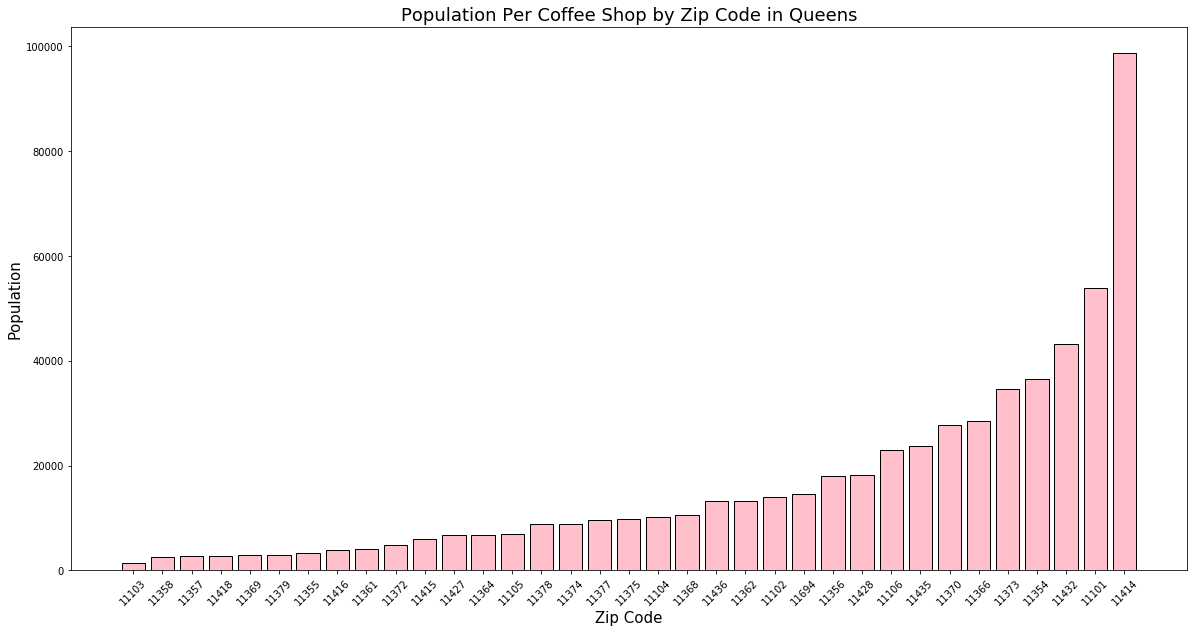

In [69]:
fig, ax = plt.subplots(figsize=(20,10))

bars = ax.bar(zip_pop_count_queens['zip_code'] , zip_pop_count_queens['customers_per_business'], color='pink', edgecolor= 'black', align='center')
ax.set_title('Population Per Coffee Shop by Zip Code in Queens', size=18)
ax.set_ylabel('Population', size=15)
ax.set_xlabel('Zip Code', size= 15)
ax.set_xticklabels(set(zip_pop_count_queens['zip_code']), rotation =45)

plt.show()

# Defining coffee shops in Queens with Highest Score By using following acquisition :

# $ Score_{best zip}=population*w_{population} + rating*w_{rating} $

# $ w_{population}$:   relevance of population per coffeeshop

# $ w_{rating}$:   relevance of average rating of zip code

In [99]:
# Adding new column to DF

zip_pop_count_queens['score'] = None
zip_pop_count_queens = zip_pop_count_queens.rename(columns={'rating':'avg_rwiev_rating'})


$ Score_{best zip}=population*w_{population} + rating*w_{rating} $

$ w_{population}$:   relevance of population per coffeeshop

$ w_{rating}$:   relevance of average rating of zip code

In [97]:
pop_coef = 0.8
rate_coef = 0.2

def calculate_score(row):
    row['score'] = row['customers_per_business'] * pop_coef + row ['avg_rwiev_rating'] * rate_coef
    row['score'] = round(row['score'])
    return row

In [98]:
scored_bus = zip_pop_count_queens.apply(calculate_score,axis=1).sort_values(['score'],ascending=False                                    
scored_bus[['zip_code','customers_per_business','avg_rwiev_rating','score']]
                                                                            

,zip_code,customers_per_business,avg_rwiev_rating,score
34,11368,98841,3.50,79074
33,11435,53877,3.50,43102
32,11370,43142,4.50,34514
31,11418,36571,4.50,29258
30,11364,34539,4.50,27632
29,11432,28522,4.25,22818
28,11355,27760,3.67,22209
27,11416,23668,4.50,18935
26,11427,23014,4.50,18412
25,11436,18148,4.50,14519
